In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, make_scorer

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [6]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [7]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [8]:
y = customer_data.pop('Churn')

In [9]:
X = customer_data

In [10]:
X_dum = pd.get_dummies(X, columns=X.select_dtypes(include='object').columns, drop_first=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=1, stratify=y)

In [12]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
cust_prec_scorer = make_scorer(precision_score, pos_label='Yes')

In [14]:
pipe_dt = make_pipeline(RandomOverSampler(random_state=1),
                        DecisionTreeClassifier(random_state=1))

pipe_dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                  'decisiontreeclassifier__max_depth': [5, 10, None],
                  'decisiontreeclassifier__min_samples_split': [2, 5, 9],
                  'decisiontreeclassifier__max_features': [0.3, 0.6, None, 'auto', 'log2']}

pipe_dt_gs = GridSearchCV(pipe_dt, pipe_dt_params, cv=5, scoring=cust_prec_scorer, n_jobs=-4, verbose=1)
pipe_dt_gs.fit(X_train, y_train)

print('Best parameters:', pipe_dt_gs.best_params_)
print('Mean cross-validated score:', pipe_dt_gs.best_score_)
print('Test score:', pipe_dt_gs.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 0.3, 'decisiontreeclassifier__min_samples_split': 2}
Mean cross-validated score: 0.5237293752384532
Test score: 0.5341207349081365


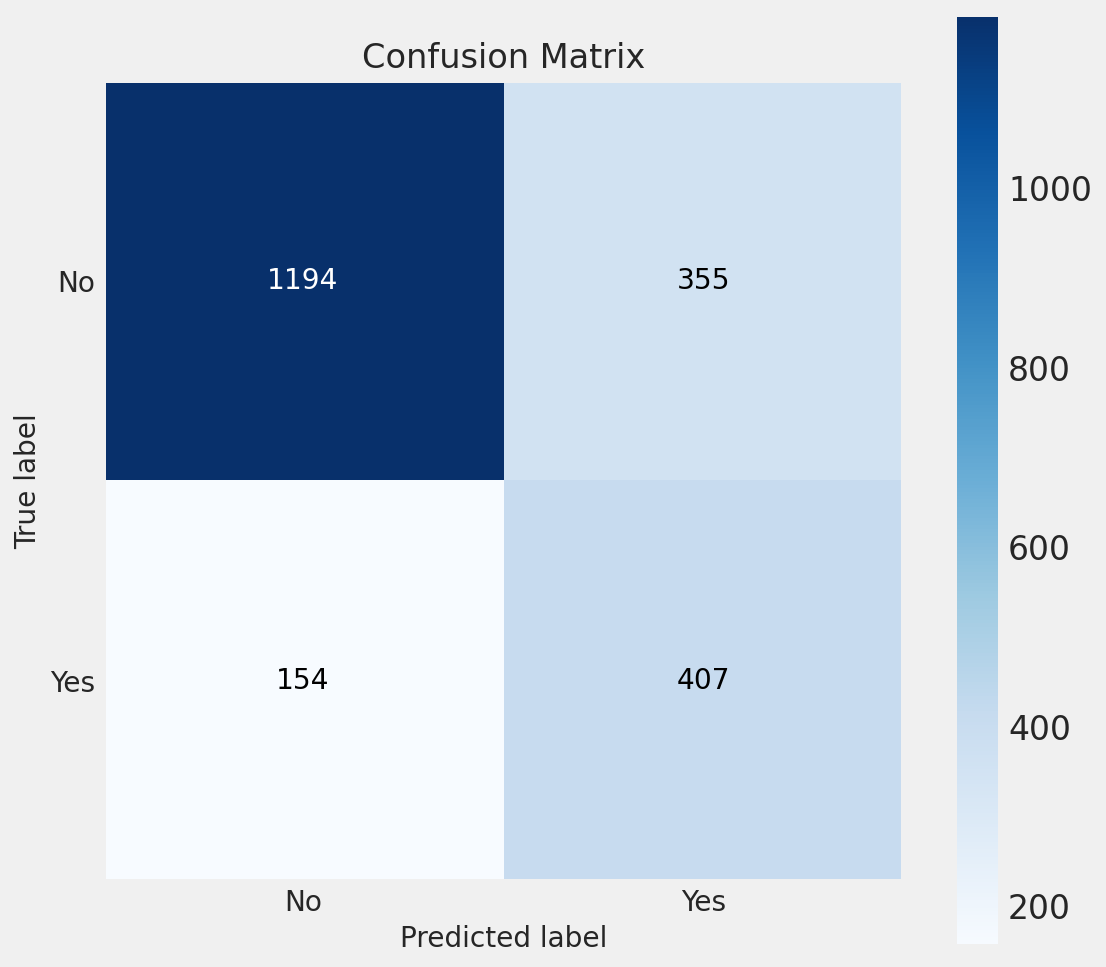

In [15]:
dt_predictions = pipe_dt_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, dt_predictions, figsize=(8, 8))
plt.show()

In [16]:
pipe_lr = make_pipeline(RandomOverSampler(random_state=1),
                        LogisticRegression(max_iter=10000))

pipe_lr_params = {'logisticregression__penalty': ['elasticnet'],
                  'logisticregression__C': [0.01, 0.05, 0.5, 1, 10, 100],
                  'logisticregression__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 0.99],
                  'logisticregression__solver': ['saga'],
                  'logisticregression__fit_intercept': [True, False]}

pipe_lr_gs = GridSearchCV(pipe_lr, pipe_lr_params, cv=5, scoring=cust_prec_scorer, n_jobs=-4, verbose=1)
pipe_lr_gs.fit(X_train, y_train)

print('Best parameters:', pipe_lr_gs.best_params_)
print('Mean cross-validated score:', pipe_lr_gs.best_score_)
print('Test score:', pipe_lr_gs.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'logisticregression__C': 0.01, 'logisticregression__fit_intercept': True, 'logisticregression__l1_ratio': 0.001, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
Mean cross-validated score: 0.5201441001392426
Test score: 0.5076201641266119


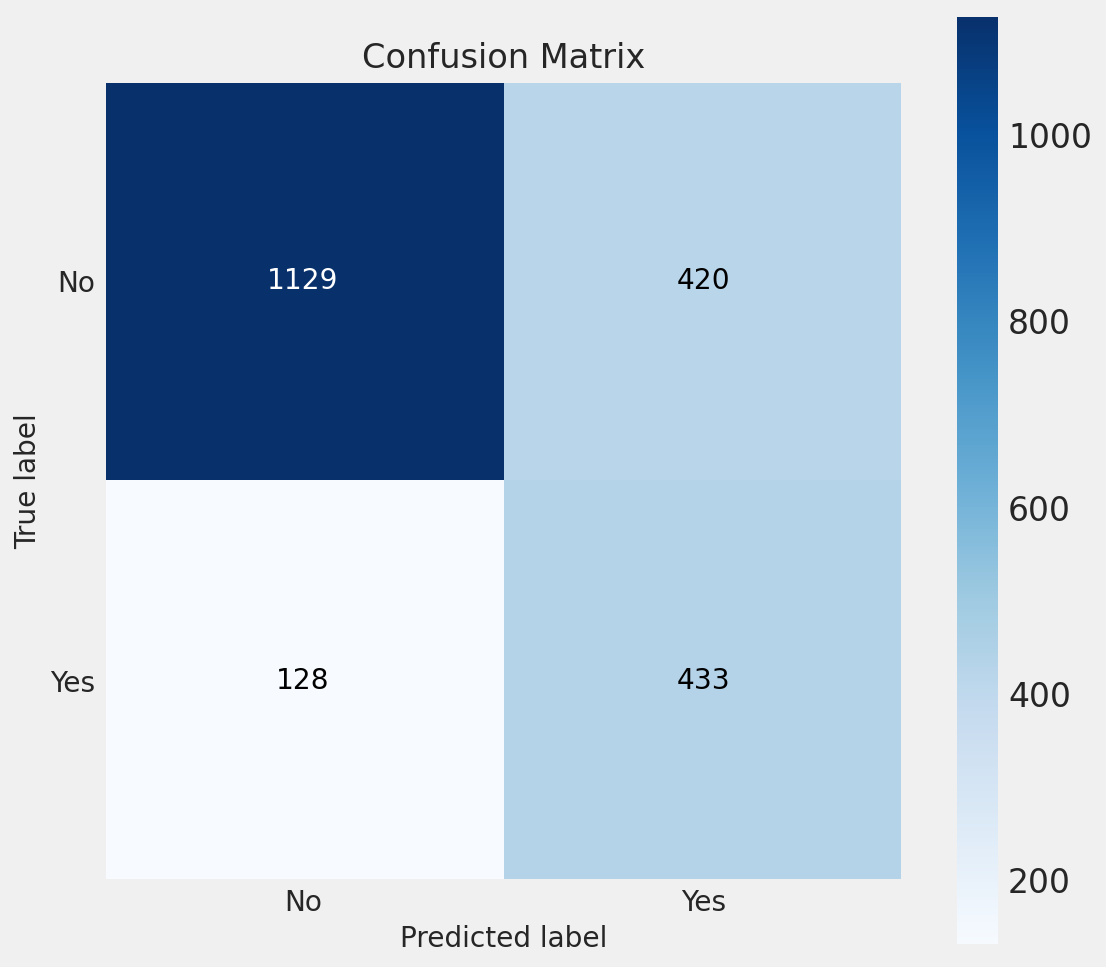

In [17]:
lr_predictions = pipe_lr_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, lr_predictions, figsize=(8, 8))
plt.show()

In [18]:
pipe_knn = make_pipeline(RandomUnderSampler(random_state=1),
                         KNeighborsClassifier())

pipe_knn_params = {'kneighborsclassifier__n_neighbors': [5, 10, 15, 20, 25],
                   'kneighborsclassifier__metric': ['manhattan', 'euclidean', 'cosine'],
                   'kneighborsclassifier__weights': ['uniform', 'distance']}

pipe_knn_gs = GridSearchCV(pipe_knn, pipe_knn_params, cv=5, scoring=cust_prec_scorer, n_jobs=28, verbose=1)
pipe_knn_gs.fit(X_train, y_train)

print('Best parameters:', pipe_knn_gs.best_params_)
print('Mean cross-validated score:', pipe_knn_gs.best_score_)
print('Test score:', pipe_knn_gs.score(X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Mean cross-validated score: 0.4876297161890806
Test score: 0.46952595936794583


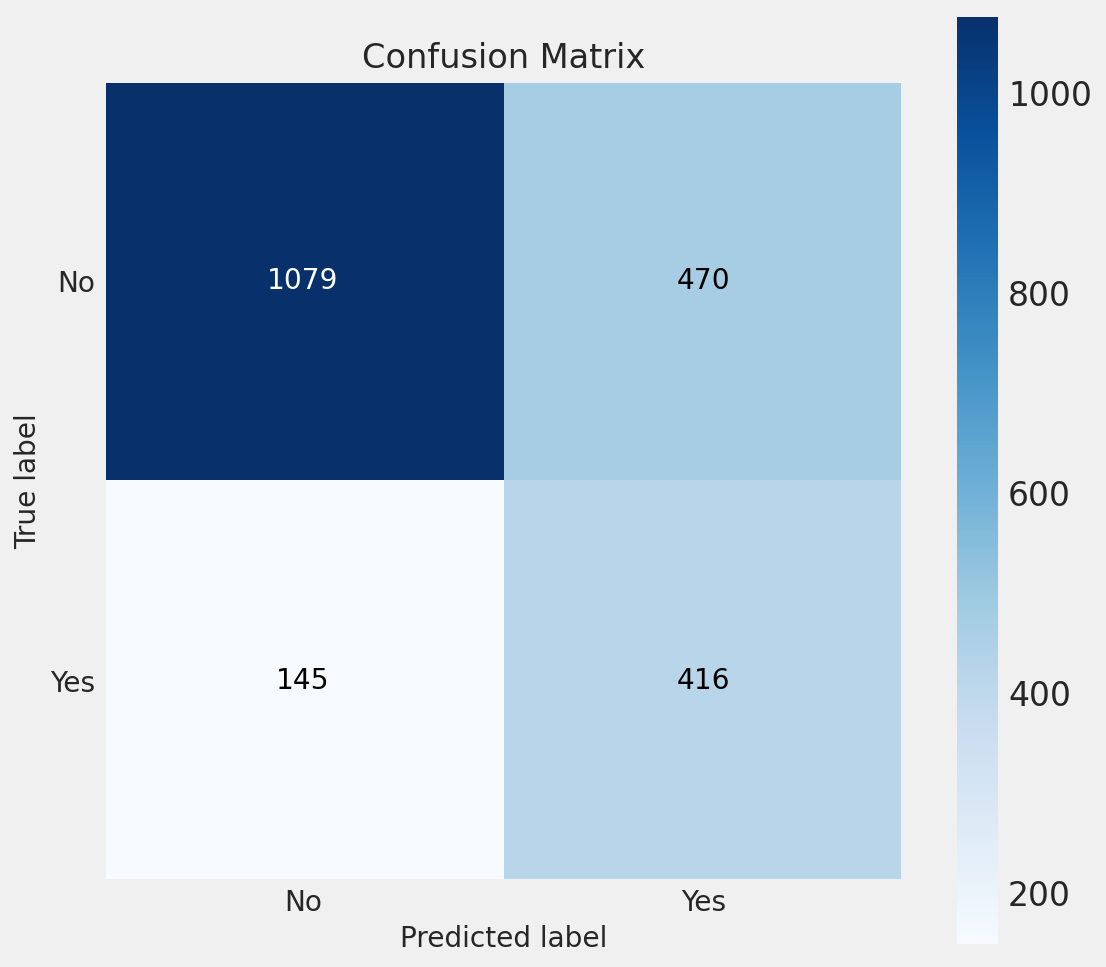

In [19]:
knn_predictions = pipe_knn_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, knn_predictions, figsize=(8, 8))
plt.show()

In [20]:
pipe_rf = make_pipeline(RandomUnderSampler(random_state=1),
                        RandomForestClassifier(random_state=1))

pipe_rf_params = {'randomforestclassifier__criterion': ['gini', 'entropy'],
                  'randomforestclassifier__max_depth': [5, 10, None],
                  'randomforestclassifier__max_features': [0.3, 0.6, 'auto'],
                  'randomforestclassifier__max_samples': [0.5, 0.8, None],
                  'randomforestclassifier__n_estimators': [30, 80, 130, 180, 230]} 

pipe_rf_gs = GridSearchCV(pipe_rf, pipe_rf_params, cv=5, scoring=cust_prec_scorer, n_jobs=28, verbose=1)
pipe_rf_gs.fit(X_train, y_train)

print('Best parameters:', pipe_rf_gs.best_params_)
print('Mean cross-validated score:', pipe_rf_gs.best_score_)
print('Test score:', pipe_rf_gs.score(X_test, y_test))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_samples': None, 'randomforestclassifier__n_estimators': 30}
Mean cross-validated score: 0.5169968246645831
Test score: 0.5017381228273464


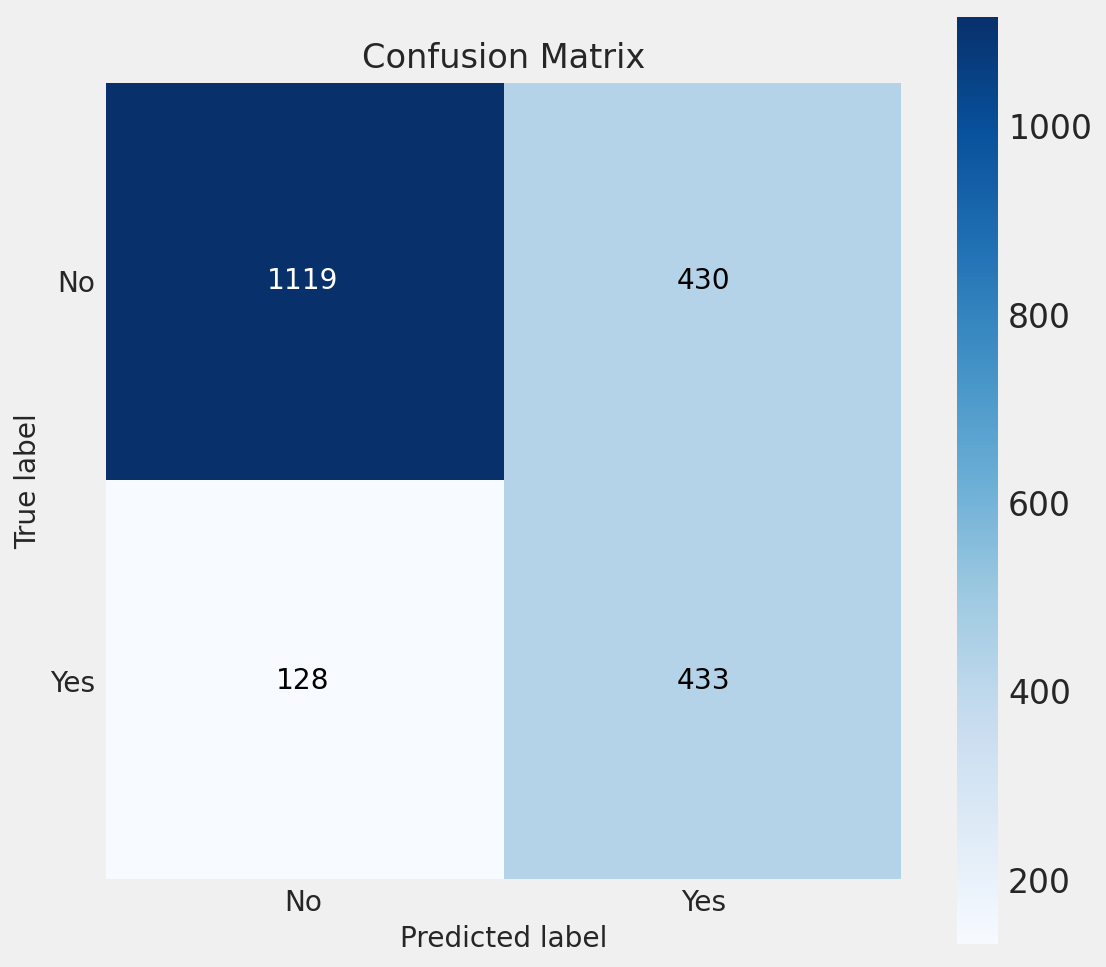

In [21]:
rf_predictions = pipe_rf_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, rf_predictions, figsize=(8, 8))
plt.show()

In [22]:
dt = DecisionTreeClassifier(random_state=1)
lr = LogisticRegression(max_iter=10000, solver='saga')

pipe_vc = make_pipeline(RandomUnderSampler(random_state=1),
                        VotingClassifier([('dt', dt), ('lr', lr)]))

pipe_vc_params = {'votingclassifier__voting': ['soft', 'hard'],
                  'votingclassifier__dt__criterion': ['gini', 'entropy'],
                  'votingclassifier__dt__max_depth': [5, 10, None],
                  'votingclassifier__dt__min_samples_split': [2, 5, 9],
                  'votingclassifier__dt__max_features': [None, 'auto', 'log2'],
                  'votingclassifier__lr__penalty': ['elasticnet'],
                  'votingclassifier__lr__C': [0.01, 0.05, 0.5, 1, 10, 100],
                  'votingclassifier__lr__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 0.99],
                  'votingclassifier__lr__fit_intercept': [True, False]}

pipe_vc_gs = GridSearchCV(pipe_vc, pipe_vc_params, cv=5, scoring=cust_prec_scorer, n_jobs=28, verbose=1)
pipe_vc_gs.fit(X_train, y_train)

print('Best parameters:', pipe_vc_gs.best_params_)
print('Mean cross-validated score:', pipe_vc_gs.best_score_)
print('Test score:', pipe_vc_gs.score(X_test, y_test))

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Best parameters: {'votingclassifier__dt__criterion': 'gini', 'votingclassifier__dt__max_depth': None, 'votingclassifier__dt__max_features': None, 'votingclassifier__dt__min_samples_split': 9, 'votingclassifier__lr__C': 0.01, 'votingclassifier__lr__fit_intercept': True, 'votingclassifier__lr__l1_ratio': 0.99, 'votingclassifier__lr__penalty': 'elasticnet', 'votingclassifier__voting': 'hard'}
Mean cross-validated score: 0.573788638309555
Test score: 0.5475040257648953


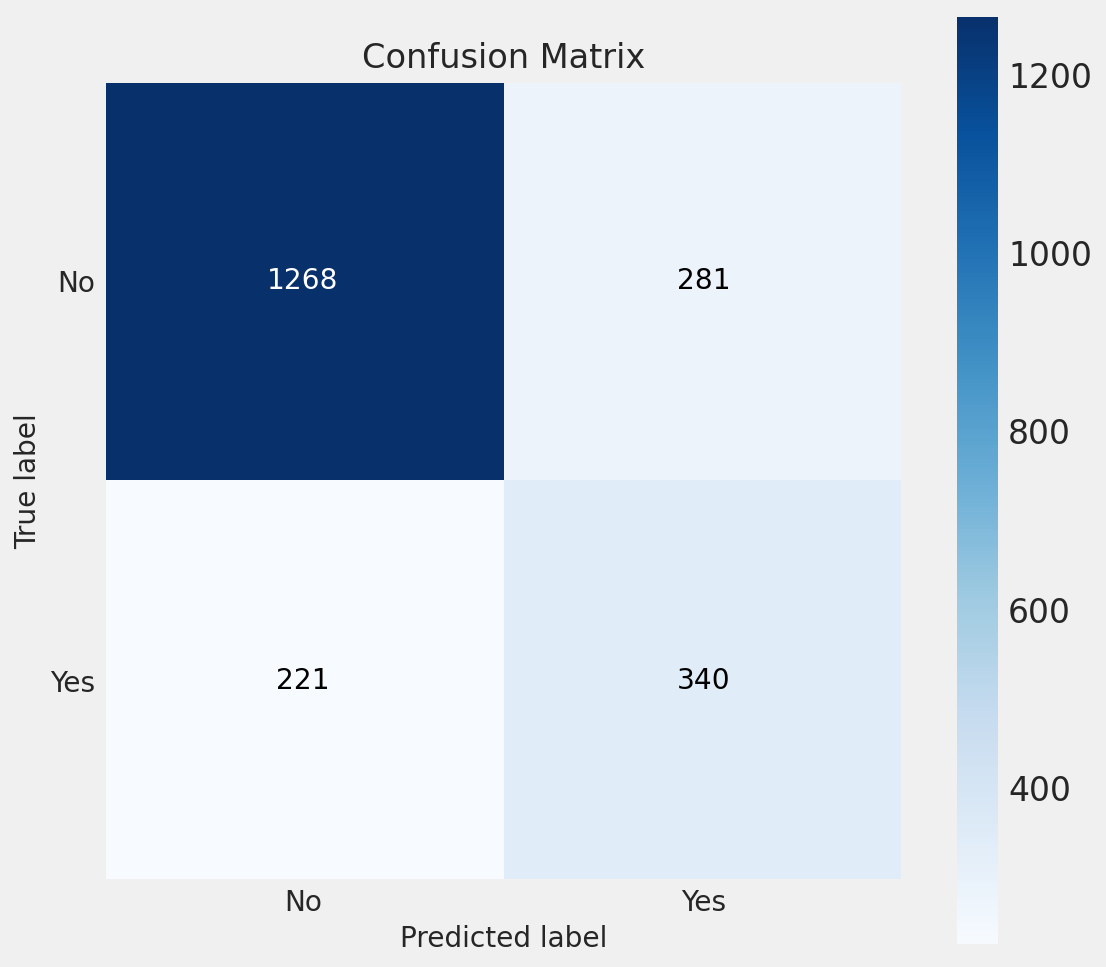

In [23]:
vc_predictions = pipe_vc_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, vc_predictions, figsize=(8, 8))
plt.show()

In [ ]:
base_estimator_dt = DecisionTreeClassifier(max_depth=3, max_features=0.3)

pipe_abc = make_pipeline(RandomUnderSampler(random_state=1),
                         AdaBoostClassifier(base_estimator_dt, n_estimators=100, random_state=1))
pipe_abc.fit(X_train, y_train)

print('Mean cross-validated score:',
          cross_val_score(pipe_abc, X_train, y_train, cv=5, scoring=cust_pres_scorer).mean())
print('Test score:', pipe_abc.score(X_test, y_test))

In [ ]:
abc_predictions = pipe_abc.estimators_[-1].predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, abc_predictions, figsize=(8, 8))
plt.show()